In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap

%matplotlib inline

# Definindo uma função

Quando estamos programando e precisamos repetir muito um trecho de código, vem a calhar criarmos uma função com este código.

Podemos co

In [4]:
def make_map(ax,llat=-30,ulat=-20,llon=-50,ulon=-39,resolution='l',nmeridians=3,nparallels=2):

    m = Basemap(projection='merc', llcrnrlat=llat, urcrnrlat=ulat, llcrnrlon=llon, urcrnrlon=ulon, resolution=resolution)

    m.ax = ax

    m.drawcoastlines(linewidth=.5)

    return m

In [5]:
# importando arquivo
DATA_DIR = '/home/danilo/mestrado/arian/'
fname = DATA_DIR + 'CARS_2009_WORLD_MONTHLY_01.nc'

ncin = xr.open_dataset(fname,decode_times=False)

In [8]:
# extraindo uma variavel qualquer para trabalhar
lon = ncin.LONGITUDE.values
lon = ((lon - 180)%360) - 180 # convertendo de 0/360 para -180/180
lat = ncin.LATITUDE.values
dep = ncin.DEPTH.values
data = ncin.TEMP[0,:,:,:] # tempo 0, todas as profs, lons e lats


Selecionamos o ponto de início do transecto (continente, por exemplo).

Nesse caso, eu olhei a grade do arquivo netcdf e identifiquei as coordenadas que eu gostaria de utilizar, pra fazer um transecto ao largo de Santos. Faz isso você também, você já fez antes.

In [17]:
# latitude e longitude do começo ao final
ilat,flat = 103, 92
ilon,flon = 626, 637

# recortando: aqui tem um pulo do gato
ndata = data[:,flat:ilat,ilon:flon]
nlon1D= lon[ilon:flon]
nlat1D= lat[flat:ilat]

# gridando a matriz de coordenadas
nlon,nlat = np.meshgrid(nlon1D,nlat1D)

# por via das duvidas, criamos um xplot,yplot para tooodo os lon e lat
xplot,yplot = np.meshgrid(lon,lat)

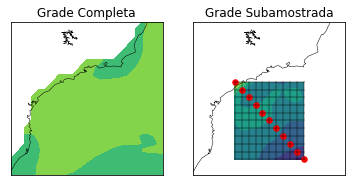

In [25]:
# visualizando o novo campo e aonde sera feito o transecto
fig,axes = plt.subplots(ncols=2)
ax=axes[0]
m = make_map(ax)
m.contourf(xplot,yplot,data[0,:,:],latlon=True)
ax.set_title('Grade Completa')

ax=axes[1]
m = make_map(ax)
m.contourf(nlon,nlat,ndata[0,:,:],latlon=True)
m.plot(nlon,nlat,'k',alpha=.3,latlon=True)
m.plot(nlon.T,nlat.T,'k',alpha=.3,latlon=True)
ax.set_title('Grade Subamostrada')

jindexes = np.arange(10,-1,-1)
iindexes = np.arange(0,11,1)
for j,i in zip(jindexes,iindexes):
    m.scatter(nlon[j,i],nlat[j,i],s=30,c='r',latlon=True)


In [27]:
# criando a martriz do transecto
transect = np.zeros(ndata.shape[0:2])*np.nan

for k in range(ndata.shape[0]):
    for j,i in zip(jindexes,iindexes):
        transect[k,i] = ndata[k,j,i]

Text(0.5,1,'Transecto ao largo de Santos')

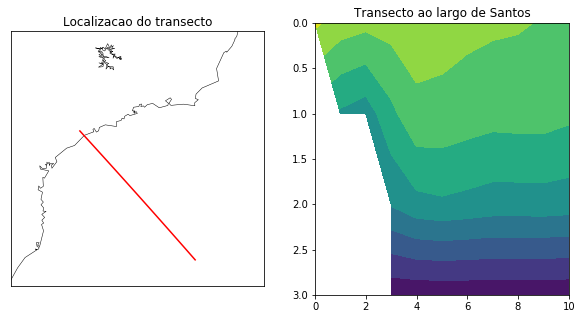

In [34]:
# visualizando a secao vertical
fig,axes = plt.subplots(ncols=2,figsize=(10,5))
ax = axes[0]
m = make_map(ax)
m.plot(nlon[jindexes,iindexes],nlat[jindexes,iindexes],'r',latlon=True)
ax.set_title('Localizacao do transecto')

ax = axes[1]
ax.contourf(transect)
ax.set_ylim([0,3])
ax.invert_yaxis()
ax.set_title('Transecto ao largo de Santos')

Os próximos passos seria plotar o contourf do transecto utilizando a profundidade, no eixo y, e a distância no eixo x. Mas não são coisas triviais de se fazer e, por hora, isso já basta pra você visualizar o comportamento dos nutrientes na coluna d'água.

Tenta fazer isso pra outras duas radiais:

. uma simples: ao largo de Cananéia
. uma complicada: ao largo de Ubatuba